### Code to Evaluate Model Performance and Classify Anomalies

Note: code uses datasets from baseline_setup.ipynb so ensure that is ran first

In [31]:
import pandas as pd
import numpy as np
from joblib import load
import xarray as xr
from pathlib import Path
from datetime import datetime, timedelta

import sys
sys.path.append('../')
import config

import matplotlib.pyplot as plt
import seaborn as sns

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [32]:
site = config.site
site_name = config.site_dict[site]
compound = config.compound

model_name = 'rf_model_MHD.joblib'
model = load(data_path/model_name)
model_type = model.__class__.__name__

print(f"Evaluating a \033[1m{model_type}\033[0;0m model on \033[1m{compound}\033[0;0m at \033[1m{site_name}\033[0;0m.")

Evaluating a RandomForestClassifier model on hfc-152a at Mace Head, Ireland.


#### Functions

In [33]:
def make_predictions():
    """
    Make predictions based on the previously trained model, taking into account model type.

    Returns:
    - results (pandas.DataFrame): DataFrame containing the predicted flags, actual flags, and mf values.
    """

    # load in data from baseline_setup.ipynb
    data_balanced_df = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', index_col='time')
    data_pca = pd.read_csv(data_path/f'for_model_pca_{compound}_{site}.csv', index_col='time')
    data_balanced_ds = xr.open_dataset(data_path/f'data_balanced_ds_{compound}_{site}.nc')

    # removing top three values from index of data_balanced_ds to match the length of the predicted flags
    # this is due to the data balancing process
    data_balanced_ds = data_balanced_ds.isel(time=slice(3, None))

    # making predictions based on model
    # remove predicted_flag if it already exists
    if "predicted_flag" in data_balanced_df.columns:
        data_balanced_df.drop(columns=["predicted_flag"], inplace=True)


    # if model is NEURAL NETWORK () - predict normally using meteorological dataset
    if model_type == 'MLPClassifier':
        df_predict = data_balanced_df.copy()
        df_predict.drop(columns=["flag"], inplace=True)
        
        print("Predcitons made using neural network model.")
        y_pred = model.predict(df_predict.reset_index(drop=True))
        data_balanced_df["predicted_flag"] = y_pred


    # if model is RANDOM FOREST - predict based on class probabilities using PCA dataset
    if model_type == 'RandomForestClassifier':
        df_predict = data_pca.copy()
        df_predict.drop(columns=["flag"], inplace=True)

        print("Predictions made using class probabilities from random forest model.")
        class_probabilities_predict = model.predict_proba(df_predict.reset_index(drop=True))

        threshold = config.confidence_threshold
        y_pred = (class_probabilities_predict[:,1] >= threshold).astype(int)

        data_balanced_df["predicted_flag"] = y_pred

    # add mf values to results
    columns_to_keep = ["flag", "predicted_flag"]
    results = data_balanced_df[columns_to_keep].copy()
    results["mf"] = data_balanced_ds.mf.values

    return results

In [34]:
def calc_statistics(results):
    """
    Calculates statistics to compare model to true flags.

    Args:
    - results (pandas.DataFrame): Dataframe containing the predicted flags, true flags, and mf values.

    Returns:
    - None
    """

    bold = '\033[1m'
    end = '\033[0m'
    
    # finds the number of predicted baseline and non-baseline values
    num_baseline = results["predicted_flag"].value_counts()[1]
    num_not_baseline = results["predicted_flag"].value_counts()[0]

    print(f'Number of predicted baseline values: {bold}{num_baseline}{end}, Number of predicted non-baseline values: {bold}{num_not_baseline}{end}')
    

    # finds mean and standard deviation of mf values for predicted and true baseline values
    actual_values = results["mf"].where((results["flag"] == 1)).dropna()
    predicted_values = results["mf"].where(results["predicted_flag"] == 1).dropna()

    actual_mean = actual_values.mean()
    predicted_mean = predicted_values.mean()

    actual_std = actual_values.std()
    predicted_std = predicted_values.std()

    print(f'True Mean: {bold}{actual_mean:.3f}{end}, Model Mean: {bold}{predicted_mean:.3f}{end}')
    print(f'True Std Dev: {bold}{actual_std:.3f}{end}, Model Std Dev: {bold}{predicted_std:.3f}{end}')


    # finds MAE, RMSE and MAPE of model monthly means
    df_pred = results.where(results["predicted_flag"] == 1).dropna()
    df_actual = results.where(results["flag"] == 1).dropna()

    df_pred.index = pd.to_datetime(df_pred.index)
    df_actual.index = pd.to_datetime(df_actual.index)
    df_pred_monthly = df_pred.resample('M').mean()
    df_actual_monthly = df_actual.resample('M').mean()
    df_pred_monthly.index = df_pred_monthly.index.to_period('M')
    df_actual_monthly.index = df_actual_monthly.index.to_period('M')

    mae = np.mean(np.abs(df_pred_monthly["mf"] - df_actual_monthly["mf"]))
    rmse = np.sqrt(np.mean((df_pred_monthly["mf"] - df_actual_monthly["mf"])**2))
    mape = np.mean(np.abs((df_actual_monthly["mf"] - df_pred_monthly["mf"]) / df_actual_monthly["mf"])) * 100

    print(f'Mean Absolute Error: {bold}{mae:.3f}{end}')
    print(f'Root Mean Squared Error: {bold}{rmse:.3f}{end}')
    print(f'Mean Absolute Percentage Error: {bold}{mape:.3f}{end}')

In [35]:
def plot_predictions(results):
    """
    Plots mole fraction against time, with the predicted baselines and true baselines highlighted.

    Args:
    - results (pandas.DataFrame): Dataframe containing the predicted flags, true flags, and mf values.
    
    Returns:
    - None
    """

    fig, ax = plt.subplots(figsize=(20,8))
    sns.set(style='whitegrid')
    sns.set_palette("colorblind")

    results["mf"].plot(ax=ax, label="All Data", alpha=0.6, color='grey', linewidth=2)
    results["mf"].where(results["predicted_flag"] == 1).plot(ax=ax, label="Predicted Baselines", color='blue', alpha=0.75, linewidth=2)
    results["mf"].where(results["flag"] == 1).plot(ax=ax, label="True Baselines", color='darkgreen', alpha=0.75, linewidth=2)

    plt.ylabel("mole fraction in air / ppt")
    plt.title(f"{compound} at {site_name}", fontsize=15)
    plt.legend(loc="lower right", fontsize=12)

In [36]:
def plot_predictions_monthly(results):
    """
    Plots the predicted baselines and their standard deviations against the true baselines and their standard deviations, highlighting any points outside three standard deviations.

    Args:
    - results (pandas.DataFrame): Dataframe containing the predicted flags, true flags, and mf values.

    Returns:
    - None
    """    
    results = results.dropna()

    # extracting flags and predicted flags
    df_pred = results.where(results["predicted_flag"] == 1).dropna()
    df_actual = results.where(results["flag"] == 1).dropna()

    df_pred.index = pd.to_datetime(df_pred.index)
    df_actual.index = pd.to_datetime(df_actual.index)

    # resampling to monthly averages
    df_pred_monthly = df_pred.resample('M').mean()
    df_actual_monthly = df_actual.resample('M').mean()
    # setting index to year and month only
    df_pred_monthly.index = df_pred_monthly.index.to_period('M')
    df_actual_monthly.index = df_actual_monthly.index.to_period('M')

    # calculating standard deviation
    std_pred_monthly = df_pred.groupby(df_pred.index.to_period('M'))["mf"].std().reset_index()
    std_pred_monthly.set_index('time', inplace=True)
    std_actual_monthly = df_actual.groupby(df_actual.index.to_period('M'))["mf"].std().reset_index()
    std_actual_monthly.set_index('time', inplace=True)


    # plotting
    fig, ax = plt.subplots(figsize=(20,8))
    sns.set(style='darkgrid')
    sns.set_palette("colorblind")

    df_actual_monthly["mf"].plot(ax=ax, label="Baselines", color='darkgreen', alpha=0.75)
    df_pred_monthly["mf"].plot(ax=ax, label="Predicted Baselines", color='blue', linestyle='--')

    # adding standard deviation shading
    upper_actual = df_actual_monthly["mf"] + std_actual_monthly['mf']
    lower_actual = df_actual_monthly["mf"] - std_actual_monthly['mf']

    ax.fill_between(df_actual_monthly.index, lower_actual, upper_actual, color='green', alpha=0.2, label="Baseline Standard Deviation")

    upper_pred = df_pred_monthly["mf"] + std_pred_monthly['mf']
    lower_pred = df_pred_monthly["mf"] - std_pred_monthly['mf']
    # ax.fill_between(df_pred_monthly.index, lower_pred, upper_pred, color='blue', alpha=0.2, label="Predicted Baseline Standard Deviation")

    # adding shading for training/validation/finetuning sets if visualised in chosen time period
    
    # Mace Head model - trained on 2013-2018, validated on 2019 (NN) or 2016-2018, validated on 2019 (RF)
    if site == 'MHD' and model_type == 'MLPClassifier':
        ax.axvspan(datetime(2013,1,1), datetime(2018,12,31), alpha=0.3, label="Training Set", color='grey')
        ax.axvspan(datetime(2019,1,1), datetime(2019,12,31), alpha=0.2, label="Validation Set", color='purple')

    elif site == 'MHD' and model_type == 'RandomForestClassifier':
        ax.axvspan(datetime(2016,1,1), datetime(2018,12,31), alpha=0.3, label="Training Set", color='grey')
        ax.axvspan(datetime(2019,1,1), datetime(2019,12,31), alpha=0.2, label="Validation Set", color='purple')

    # Gosan model
    elif site == 'GSN' and "finetuned" not in model_name and model_type == 'MLPClassifier':
        ax.axvspan(datetime(2009,1,1), datetime(2013,12,31), alpha=0.3, label="Training Set", color='grey')
        ax.axvspan(datetime(2014,1,1), datetime(2014,12,31), alpha=0.2, label="Validation Set", color='purple')

    elif site == 'GSN' and "finetuned" not in model_name and model_type == 'RandomForestClassifier':
        ax.axvspan(datetime(2011,1,1), datetime(2013,12,31), alpha=0.3, label="Training Set", color='grey')
        ax.axvspan(datetime(2014,1,1), datetime(2014,12,31), alpha=0.2, label="Validation Set", color='purple')

    # Gosan finetuned model - finetuned on 2013-2014 for NN and 2014 for RF
    elif site == 'GSN' and "finetuned" in model_name and model_type == 'MLPClassifier':
        ax.axvspan(datetime(2013,1,1), datetime(2014,12,31), alpha=0.2, label="Fine-tuning Set", color='orange')

    elif site == 'GSN' and "finetuned" in model_name and model_type == 'RandomForestClassifier':
        ax.axvspan(datetime(2014,1,1), datetime(2014,12,31), alpha=0.2, label="Fine-tuning Set", color='orange')


    # adding tolerance range based on 3 standard deviations
    upper_range = df_actual_monthly["mf"] + 3*(std_actual_monthly['mf'])
    lower_range = df_actual_monthly["mf"] - 3*(std_actual_monthly['mf'])

    # calculating overall standard deviation for arrows
    overall_std = df_actual_monthly["mf"].std()


    # adding labels to points outside tolerance range
    # looping through in this way as indexes don't always match up (i.e. in the case that no predictions are made in a month)
    for idx, row in df_pred_monthly.iterrows():
        if idx in upper_range.index and row["mf"] >= upper_range.loc[idx]:
            arrow_end = row["mf"] + (overall_std * 0.5)
            ax.annotate(idx.strftime('%B %Y'),
                        xy=(idx, row["mf"]),
                        xytext=(idx, arrow_end),
                        arrowprops=dict(facecolor='black', shrink=0.05),
                        horizontalalignment='center', verticalalignment='bottom')
        
        elif idx in upper_range.index and row["mf"] <= lower_range.loc[idx]:
            arrow_end = row["mf"] - (overall_std * 0.5)
            ax.annotate(idx.strftime('%B %Y'),
                        xy=(idx, row["mf"]),
                        xytext=(idx, arrow_end),
                        arrowprops=dict(facecolor='black', shrink=0.05),
                        horizontalalignment='center', verticalalignment='bottom')

    plt.ylabel("mole fraction in air / ppt")
    plt.title(f"Comparing True and Predicted Baseline Monthly Means for {compound} at {site_name}", fontsize=15)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()

In [37]:
def quantify_noise(results):
    """
    Quantifies the noise in the true baselines, by calculating the coefficient of variation of the true baseline values based on detrended aggregate data.
    This is a relative measure of dispersion, calculated as the standard deviation divided by the mean, allowing for comparison between different datasets. 
    A higher coefficient of variation indicates a higher level of dispersion.

    Args:
    - results (pandas.DataFrame): Dataframe containing the predicted flags, true flags, and mf values.

    Returns:
    - None
    """

    # extracting true baseline values
    df_actual = results.where(results["flag"] == 1).dropna()
    df_actual.index = pd.to_datetime(df_actual.index)

    # resampling to monthly averages
    df_actual_monthly = df_actual.resample('M').mean()
    df_actual_monthly.index = df_actual_monthly.index.to_period('M')

    # detrending
    df_actual_monthly['detrended'] = df_actual_monthly['mf'] - df_actual_monthly['mf'].rolling(window=12).mean()
    
    # calculating coefficient of variation
    cv = df_actual_monthly['detrended'].std() / df_actual_monthly['detrended'].mean()

    print(f'Coefficient of Variation of True Baseline Values: {cv:.3f}')

In [39]:
def plot_predictions_monthly_filtered(results, start_year, end_year):
    """
    Plots the predicted baselines and their standard deviations against the true baselines and their standard deviations, highlighting any points outside three standard deviations.
    The plot is filtered to only show the years specified.

    Args:
    - results (pandas.DataFrame): Dataframe containing the predicted flags, true flags, and mf values.

    Returns:
    - None
    """    

    results = results.dropna()

    # extracting flags and predicted flags
    df_pred = results.where(results["predicted_flag"] == 1).dropna()
    df_actual = results.where(results["flag"] == 1).dropna()

    df_pred.index = pd.to_datetime(df_pred.index)
    df_actual.index = pd.to_datetime(df_actual.index)

    # resampling to monthly averages
    df_pred_monthly = df_pred.resample('M').mean()
    df_actual_monthly = df_actual.resample('M').mean()
    # setting index to year and month only
    df_pred_monthly.index = df_pred_monthly.index.to_period('M')
    df_actual_monthly.index = df_actual_monthly.index.to_period('M')

    # calculating standard deviation
    std_pred_monthly = df_pred.groupby(df_pred.index.to_period('M'))["mf"].std().reset_index()
    std_pred_monthly.set_index('time', inplace=True)
    std_actual_monthly = df_actual.groupby(df_actual.index.to_period('M'))["mf"].std().reset_index()
    std_actual_monthly.set_index('time', inplace=True)


    # filtering to only show the years specified
    df_pred_monthly = df_pred_monthly.loc[start_year:end_year]
    df_actual_monthly = df_actual_monthly.loc[start_year:end_year]
    std_pred_monthly = std_pred_monthly.loc[start_year:end_year]
    std_actual_monthly = std_actual_monthly.loc[start_year:end_year]

    # plotting
    fig, ax = plt.subplots(figsize=(20,8))
    sns.set(style='whitegrid')
    sns.set_palette("colorblind")

    df_actual_monthly["mf"].plot(ax=ax, label="Baselines", color='darkgreen', alpha=0.75)
    df_pred_monthly["mf"].plot(ax=ax, label="Predicted Baselines", color='blue', linestyle='--')

    # adding standard deviation shading
    upper_actual = df_actual_monthly["mf"] + std_actual_monthly['mf']
    lower_actual = df_actual_monthly["mf"] - std_actual_monthly['mf']

    ax.fill_between(df_actual_monthly.index, lower_actual, upper_actual, color='green', alpha=0.2, label="Baseline Standard Deviation")

    upper_pred = df_pred_monthly["mf"] + std_pred_monthly['mf']
    lower_pred = df_pred_monthly["mf"] - std_pred_monthly['mf']
    # ax.fill_between(df_pred_monthly.index, lower_pred, upper_pred, color='blue', alpha=0.2, label="Predicted Baseline Standard Deviation")

    if df_actual_monthly.index[0].year >= 2016 and df_actual_monthly.index[-1].year <= 2018:
        ax.axvspan(datetime(2016,1,1), datetime(2018,12,31), alpha=0.2, label="Training Set", color='grey')
    if df_actual_monthly.index[0].year >= 2019 and df_actual_monthly.index[-1].year <= 2019:
        ax.axvspan(datetime(2019,1,1), datetime(2019,12,31), alpha=0.2, label="Validation Set", color='purple')

    
    # adding tolerance range based on 3 standard deviations
    upper_range = df_actual_monthly["mf"] + 3*(std_actual_monthly['mf'])
    lower_range = df_actual_monthly["mf"] - 3*(std_actual_monthly['mf'])

    # calculating overall standard deviation for arrows
    overall_std = df_actual_monthly["mf"].std()


    # adding labels to points outside tolerance range
    # looping through in this way as indexes don't always match up (i.e. in the case that no predictions are made in a month)

    for idx, row in df_pred_monthly.iterrows():
        if idx in upper_range.index and row["mf"] >= upper_range.loc[idx]:
            arrow_end = row["mf"] + (overall_std * 0.5)
            ax.annotate(idx.strftime('%B %Y'),
                        xy=(idx, row["mf"]),
                        xytext=(idx, arrow_end),
                        arrowprops=dict(facecolor='black', shrink=0.05),
                        fontsize=15,
                        horizontalalignment='center', verticalalignment='bottom')
        
        elif idx in upper_range.index and row["mf"] <= lower_range.loc[idx]:
            arrow_end = row["mf"] - (overall_std * 0.5)
            ax.annotate(idx.strftime('%B %Y'),
                        xy=(idx, row["mf"]),
                        xytext=(idx, arrow_end),
                        arrowprops=dict(facecolor='black', shrink=0.05),
                        fontsize=15,
                        horizontalalignment='center', verticalalignment='bottom')
            
      
    if start_year == end_year:
        plt.title(f"Comparing True and Predicted Baseline Monthly Means for {compound} at {site_name}, {start_year}", fontsize=15)
    else:
        plt.title(f"Comparing True and Predicted Baseline Monthly Means for {compound} at {site_name}, {start_year} - {end_year}", fontsize=15)

    plt.ylabel("mole fraction in air / ppt")
    plt.legend(loc="lower right", fontsize=12)
    plt.show()

In [40]:
def analyse_anomalies(results, anomalies_list):
    """
    Plots a given set of anomalous months, comparing the predicted baselines to the true baselines.
    Works when considering two or more anomalous months.

    Args:
    - results (pandas.DataFrame): Dataframe containing the predicted flags, true flags, and mf values.
    - anomalies_list (list): A list of strings representing the anomalous months in the format 'YYYY-MM'.

    Returns:
    - None
    """    
    def get_days(month):
        """
        Returns the start and end dates of a given month. Only used for plotting anomalies.

        Args:
        - month (str): A string representing the month in the format 'YYYY-MM'.

        Returns:
        - tuple: A tuple containing the start date and end date of the month in the format 'YYYY-MM-DD'.
        """
        start_date = datetime.strptime(month, "%Y-%m")
        end_date = (start_date + timedelta(days=31)).replace(day=1) - timedelta(days=1)
        return start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
    

    # getting start and end dates for each anomalous month
    anomalies_range_list = [day for month in anomalies_list for day in get_days(month)]

    # plotting
    figsize_list = [8, 10, 18, 25, 30, 40, 50, 60, 70, 80, 90, 100]

    if len(anomalies_list) == 1:
        fig, axs = plt.subplots(1, 2, figsize=(20,8))
        sns.set(style='darkgrid')
        sns.set_palette("colorblind")

        start, end = anomalies_range_list[0], anomalies_range_list[1]
        month = results.loc[start:end]
        month.index = pd.to_datetime(month.index)
        # calculating some stats
        pred_mean = month["mf"].where(month["predicted_flag"] == 1).mean()
        actual_mean = month["mf"].where(month["flag"] == 1).mean()
        pred_count = month["mf"].where(month["predicted_flag"] == 1).count()
        actual_count = month["mf"].where(month["flag"] == 1).count()

        # plotting baseline points
        axs[0].scatter(month.index, month["mf"].where(month["flag"] == 1),
                    color='darkgreen', label=f"Baselines (count={actual_count})", marker='x', s=75)
        axs[0].scatter(month.index, month["mf"].where(month["predicted_flag"] == 1),
                    color='blue', label=f"Predicted Baselines (count={pred_count})", marker='x', s=75)
        # plotting mean lines
        axs[0].axhline(y=actual_mean, color='darkgreen', linestyle='-', label='Actual Mean')
        axs[0].axhline(y=pred_mean, color='blue', linestyle='-', label='Predicted Mean')

        # adding tolerance limit line
        actual_std = month["mf"].where(month["flag"] == 1).std()
        upper_limit = actual_mean + (3*actual_std)
        lower_limit = actual_mean - (3*actual_std)
        axs[0].axhline(y=upper_limit, color='darkgreen', linestyle=':')
        axs[0].axhline(y=lower_limit, color='darkgreen', linestyle=':')
        axs[0].fill_between(month.index, lower_limit, upper_limit, color='green', alpha=0.1, label="Tolerance Range")

        # formatting plot
        start_date = datetime.strptime(start, '%Y-%m-%d')
        formatted_date = start_date.strftime('%b %Y')
        axs[0].set_title(f"{formatted_date}", fontsize=20)
        axs[0].set_ylabel("mole fraction in air / ppt")
        axs[0].legend(fontsize=14)

        # comparing counts
        counts = []
        true_positive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 1)).count()
        false_postive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 0)).count()
        true_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 0)).count()
        false_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 1)).count()
        counts.append(true_positive_count)
        counts.append(false_postive_count)
        counts.append(true_negative_count)
        counts.append(false_negative_count)

        axs[1].bar(["True Positive", "False Positive", "True Negative", "False Negative"], counts, color='grey')

        for i in range(len(counts)):
            percentage = counts[i] / month["mf"].count() * 100
            axs[1].text(i, counts[i], f"{counts[i]} ({percentage:.1f}%)", fontsize=10, ha='center', va='bottom')


    else:
        fig, axs = plt.subplots(len(anomalies_list), 2, 
                                figsize=(20,figsize_list[len(anomalies_list)-1]))
        
        sns.set(style='darkgrid')
        sns.set_palette("colorblind")
        
        for n in range(0, len(anomalies_list)):
            start, end = anomalies_range_list[2*n], anomalies_range_list[2*n+1]
            month = results.loc[start:end]
            month.index = pd.to_datetime(month.index)
            # calculating some stats
            pred_mean = month["mf"].where(month["predicted_flag"] == 1).mean()
            actual_mean = month["mf"].where(month["flag"] == 1).mean()
            pred_count = month["mf"].where(month["predicted_flag"] == 1).count()
            actual_count = month["mf"].where(month["flag"] == 1).count()

            # plotting baseline points
            axs[n,0].scatter(month.index, month["mf"].where(month["flag"] == 1), 
                        color='darkgreen', label=f"True Baselines (count={actual_count})", marker='x', s=75)
            axs[n,0].scatter(month.index, month["mf"].where(month["predicted_flag"] == 1), 
                        color='blue', label=f"Predicted Baselines (count={pred_count})", marker='x', s=75)
            # plotting mean lines
            axs[n,0].axhline(y=actual_mean, color='darkgreen', linestyle='-', label='True Mean')
            axs[n,0].axhline(y=pred_mean, color='red', linestyle='-', label='Predicted Mean') 

            # adding tolerance limit line
            actual_std = month["mf"].where(month["flag"] == 1).std()
            upper_limit = actual_mean + (3*actual_std)
            lower_limit = actual_mean - (3*actual_std)
            axs[n,0].axhline(y=upper_limit, color='darkgreen', linestyle=':')
            axs[n,0].axhline(y=lower_limit, color='darkgreen', linestyle=':')
            axs[n,0].fill_between(month.index, lower_limit, upper_limit, color='green', alpha=0.1, label="Tolerance Range")

            # formatting plot
            start_date = datetime.strptime(start, '%Y-%m-%d')
            formatted_date = start_date.strftime('%b %Y')
            axs[n,0].set_title(f"{formatted_date}", fontsize=20)
            axs[n,0].set_ylabel("mole fraction in air / ppt")
            axs[n,0].legend(fontsize=14)
            
            # comparing counts
            counts = []
            true_positive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 1)).count()
            false_postive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 0)).count()
            true_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 0)).count()
            false_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 1)).count()
            counts.append(true_positive_count)
            counts.append(false_postive_count)
            counts.append(true_negative_count)
            counts.append(false_negative_count)

            axs[n,1].bar(["True Positive", "False Positive", "True Negative", "False Negative"], counts, color='grey')

            for i in range(len(counts)):
                percentage = counts[i] / month["mf"].count() * 100
                axs[n,1].text(i, counts[i], f"{counts[i]} ({percentage:.1f}%)", fontsize=10, ha='center', va='bottom')


    fig.suptitle(f"Anomalous Months for {compound} at {site_name}", fontsize=25, y=1.01)
    fig.set_tight_layout(True)
    plt.show()

#### Results

In [41]:
results = make_predictions()

Predictions made using class probabilities from random forest model.


In [42]:
calc_statistics(results)

Number of predicted baseline values: 27561, Number of predicted non-baseline values: 18644
True Mean: 8.301, Model Mean: 8.419
True Std Dev: 2.756, Model Std Dev: 2.712
Mean Absolute Error: 0.076
Root Mean Squared Error: 0.262
Mean Absolute Percentage Error: 0.971


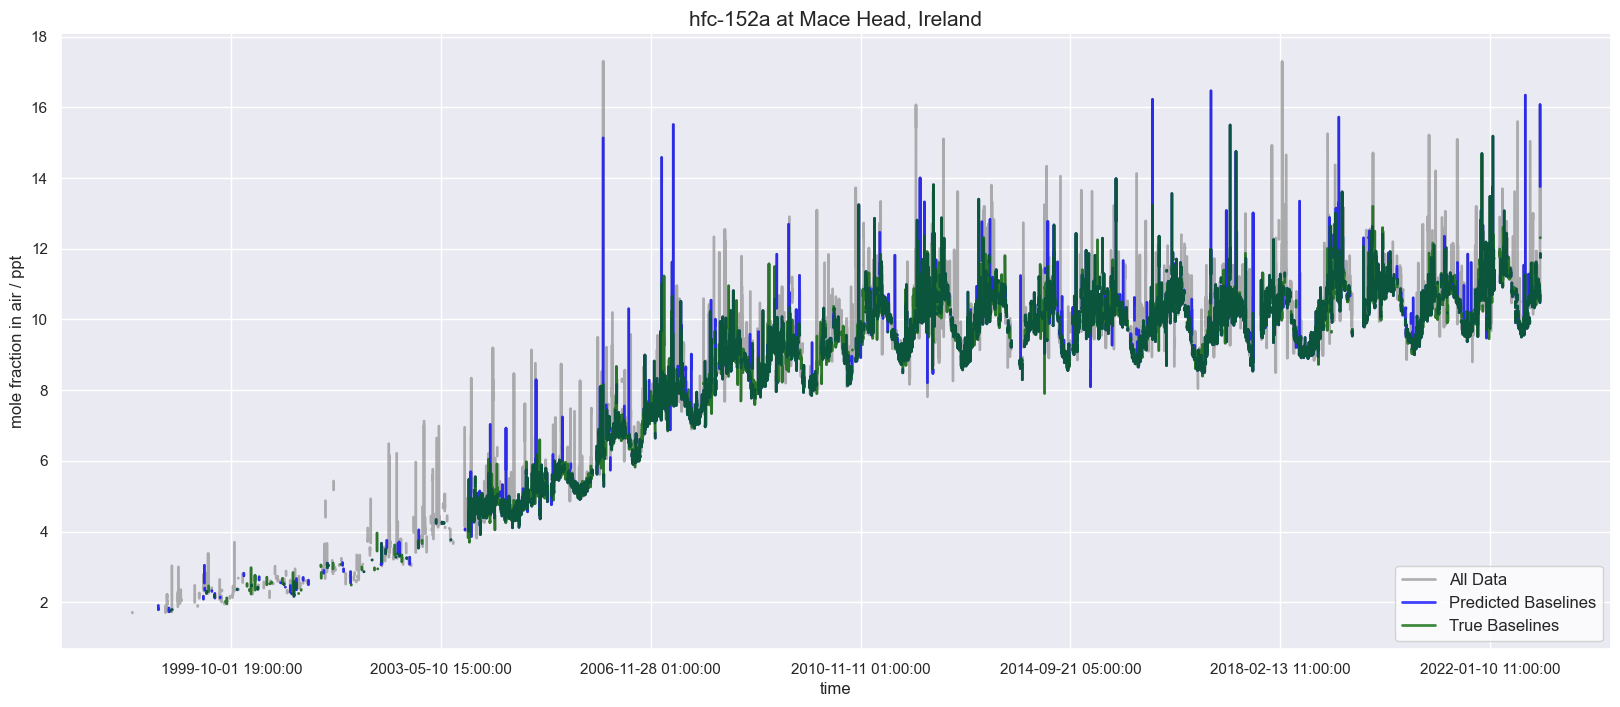

In [43]:
plot_predictions(results)

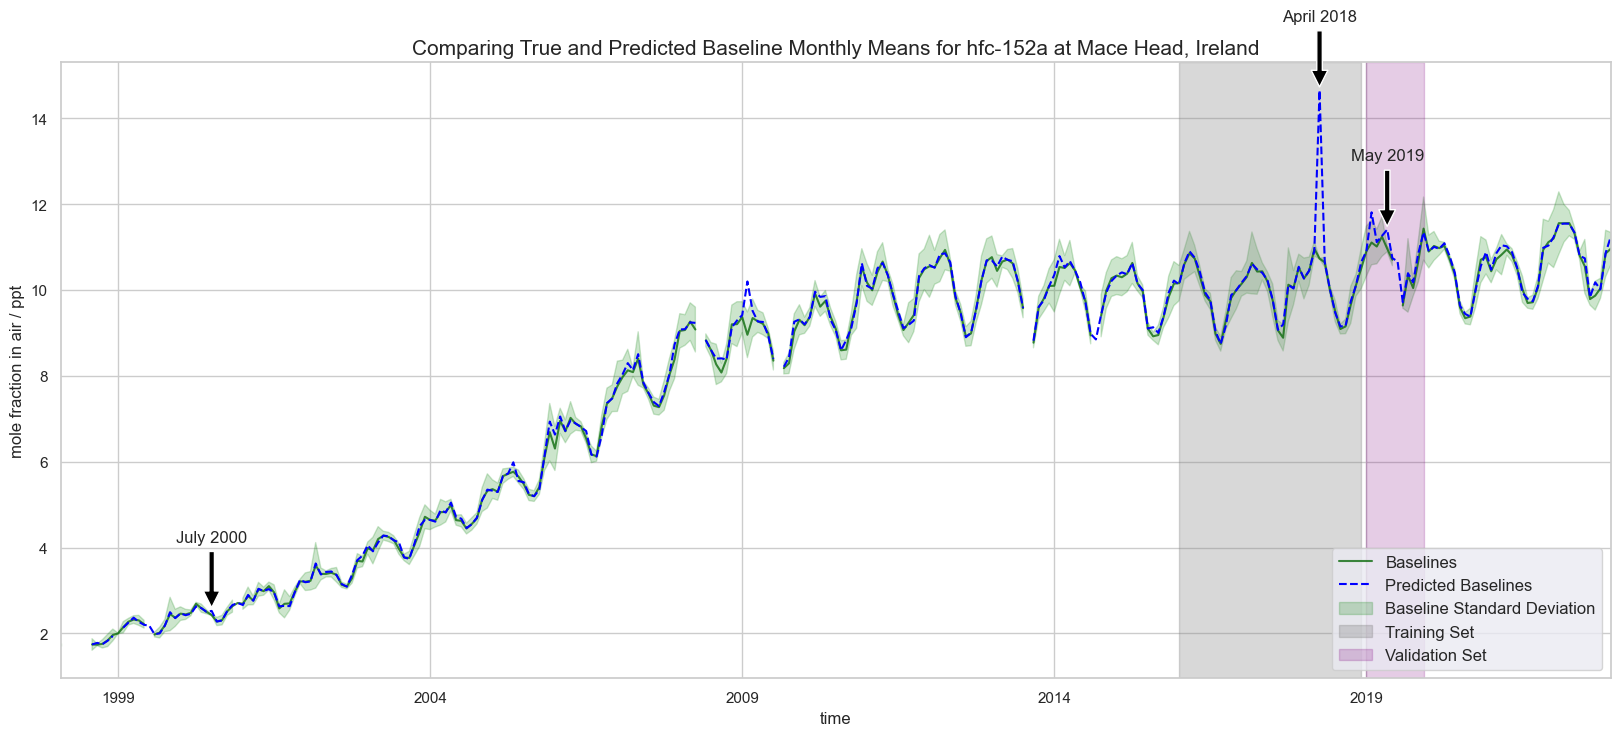

In [44]:
plot_predictions_monthly(results)

In [45]:
quantify_noise(results)
quantify_noise_2(results)

Coefficient of Variation of True Baseline Values: 2.782
Coefficient of Variation of True Baseline Values after detrending: 2.782


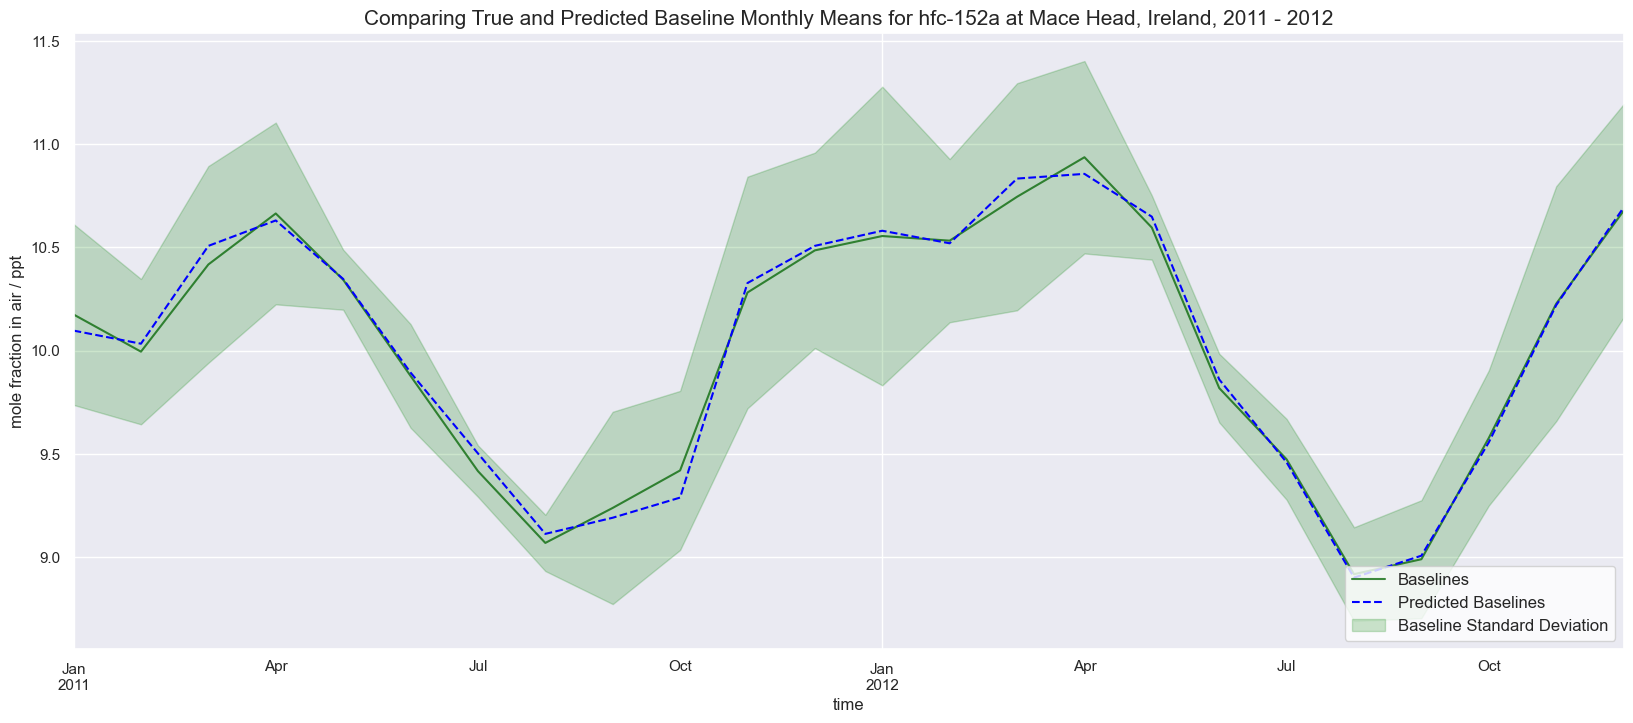

In [46]:
plot_predictions_monthly_filtered(results, '2011', '2012')

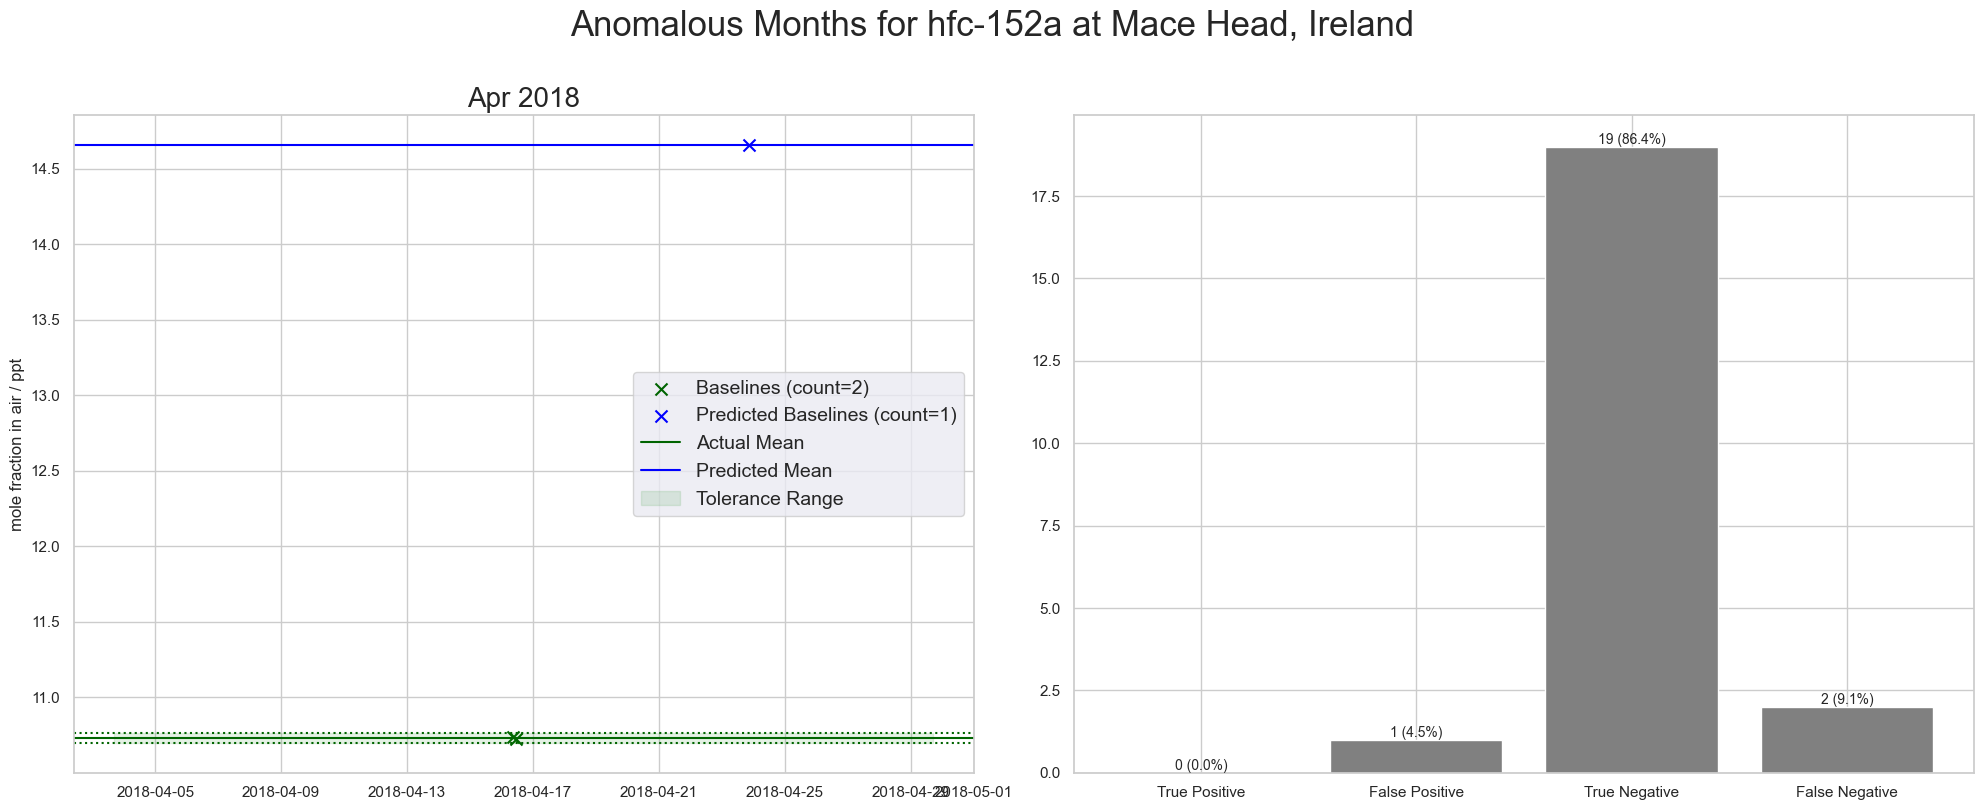

In [47]:
anomalies_list = ['2018-04']
analyse_anomalies(results, anomalies_list)